# Исследование бизнес-показателей

В нашем распоряжении данные о пользователях развлекательного приложения, привлеченных с 1 мая по 27 октября  2019 года: журнал об их посещениях, выгрузка их покупок за этот период, рекламные расходы.    

Необходимо разобраться почему приложение терпит убытки на протяжении последних нескольких месяцев, несмотря на огромные вложения в рекламу, и помочь компании выйти в плюс.

**ЦЕЛЬ ИССЛЕДОВАНИЯ**:
1. Проверить гипотезу "Коэффициент окупаемости ROI меньше 1".   
2. Если гипотеза подтвердится, выявить причины.

**ХОД ИССЛЕДОВАНИЯ**

Данные о пользователях получили из трех файлов: visits_info_short.csv, orders_info_short.csv и costs_info_short.csv .   
О качестве данных ничего не известно. Поэтому перед исследованием данных и расчетом показателей понадобится их обзор и предобработка. Проверим данные на ошибки и оценим их влияние на исследование.   
Таким образом, исследование пройдёт в пять этапов:

1. Обзор и предобработка данных.
2. Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии.
3. Исследовательский анализ данных.
4. Маркетинг.
5. Оценка окупаемости рекламы.

### Загрузка данных и подготовка их к анализу

Импортируем нужные библиотеки и загрузим данные в переменные `visits`, `orders` и `costs`:

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
#загружаем данные в переменные
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # визиты
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

---

Для быстрого изучения данных создадим функцию `data_info`, которая выведет на экран первые 5 строк таблицы, основную инфоромацию по ней с типами данных каждого признака, информацию о числе пропусков и о количистве дубликатов.

In [3]:
def data_info(df):
    # выводим первые 5 строк датафрема
    display(df.head())
    # применяем метод info()
    print()
    print('Общая информация:')
    print(df.info())
    print()
    # считаем пропущенные значения:
    print('Число пропущенных значений:')
    print(df.isna().sum())
    print()
    # находим число строк-дубликатов в датафреме
    print('Количество строк-дубликатов:', df.duplicated().sum())

---

Выполним обзор данных, поочередно применив функцию `data_info` к нашим датафреймам и предобработаем данные в случае необходимости.

#### Датафрейм "visits"

In [4]:
data_info(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

Число пропущенных значений:
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 2px; padding: 20px">  
    
В таблице 6 столбцов. Встречаются разные типы данных в столбцах: int64 и object.

Согласно документации:    
**User Id** — уникальный идентификатор пользователя;    
**Region** — страна пользователя;   
**Device** — тип устройства пользователя;   
**Channel** — идентификатор источника перехода;   
**Session Start** — дата и время начала сессии;   
**Session End** — дата и время окончания сессии.


В названиях колонок видны нарушения стиля, над которым нужно поработать.  
Некоторые типы данных не соответствуют заявленному описанию: в колонках с датой и временем должен быть тип datetime.   
Пропущенных значений в датафрейме нет, строки-дубликаты отсутствуют.

Приведем названия столбцов в соответствие с хорошим стилем, а также изменим тип колонок с датами на datetime:

In [5]:
#изменяем названия колонок
visits.columns = [c.lower().replace(' ','_') for c in visits.columns]

#изменяем тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# выведем обновленную информацию для проверки
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

Проверим столбцы `region`, `device` и `channel` на наличие неявных дубликатов. Для этого выведем уникальные значения данных колонок

In [6]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].sort_values().unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


Неявных дубликатов не выявлено.

#### Датафрейм "orders"

In [7]:
data_info(orders)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

Число пропущенных значений:
User Id     0
Event Dt    0
Revenue     0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 2px; padding: 20px">  
    
В таблице 3 столбца. Встречаются разные типы данных в столбцах: int64, float64 и object. 

Согласно документации:    
**User Id** — уникальный идентификатор пользователя;    
**Event Dt** — дата и время покупки;   
**Revenue** — сумма заказа.   

В названиях колонок также видны нарушения стиля.  
Тип данных признака `Event Dt` не соответствует заявленному описанию.  
Пропущенных значений в датафрейме нет, строки-дубликаты отсутствуют.

Таким образом, приведем названия столбцов в соответствие с хорошим стилем, а также изменим тип колонок с датами на datetime:

In [8]:
#изменяем названия колонок
orders.columns = [c.lower().replace(' ','_') for c in orders.columns]

#изменяем тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

# выведем обновленную информацию для проверки
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

#### Датафрейм "costs"

In [9]:
data_info(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

Число пропущенных значений:
dt         0
Channel    0
costs      0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 2px; padding: 20px">  
    
В таблице 3 столбца. Встречаются разные типы данных в столбцах: float64 и object. 

Согласно документации:    
**dt** — дата проведения рекламной кампании;   
**Channel** — идентификатор рекламного источника;   
**costs** — расходы на эту кампанию.    


В названиях колонок также видны нарушения стиля.  
Тип данных признака `dt` нужно заменить на datetime.  
Пропущенных значений в датафрейме нет, строки-дубликаты отсутствуют.

Также приведем названия столбцов в соответствие с хорошим стилем и изменим тип колонок с датами на datetime и выделим из нее дату.

In [10]:
#изменяем названия колонок
costs.columns = costs.columns.str.lower()

#изменяем тип данных
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# выведем обновленную информацию для проверки
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

Проверим столбец `channel` на наличие неявных дубликатов. Для этого выведем уникальные значения данных колонок.

In [11]:
costs['channel'].sort_values().unique()

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds'], dtype=object)

Неявных дубликатов не выявлено.


**Вывод**   
Данные загружены и предобработаны, пропуски и дубликаты не выявлены, столбцы с данными о времени приведены к нужному типу, исправлен стиль заголовков.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Создадим функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

---

#### Функции для вычисления значений метрик

**Функция для создания пользовательских профилей:**

In [12]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


**- функция для расчёта удержания (Retention Rate):**


In [13]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**- функция для расчёта конверсии:**

In [14]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**- функция для расчёта LTV и ROI:**

In [15]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков

**- функция для сглаживания фрейма:**

In [16]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**- функция для визуализации удержания:**

In [17]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**- функция для визуализации конверсии:**

In [18]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**- функция для визуализации LTV и ROI:**

In [19]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

---

#### Составление профилей пользователей

Составим профили пользователей с помощью применения функции `get_profiles()`, передав ей данные о посещениях, покупках,   и тратах на рекламу, выведем первые 5 строк полученной таблицы `profiles`:

In [20]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Установим момент и горизонт анализа данных. По условию задания на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, таким образом, получаем:

In [21]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Определим минимальную и максимальную даты привлечения пользователей:

In [22]:
# определяем минимальную дату привлечения пользователей
min_analysis_date = profiles['dt'].min()

# определяем максимально возможную дату привлечения с учётом горизонта:
max_analysis_date = observation_date - timedelta(days=horizon_days - 1)

print('Минимальная дата привлечения пользователей:', min_analysis_date)
print('Максимально возможная дата привлечения пользователей с учетом горизонта:', max_analysis_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимально возможная дата привлечения пользователей с учетом горизонта: 2019-10-19


**Выводы:**     
Данные с профилями пользователей получены и сохранены в переменной `profiles`.   

Согласно условию задачи, установлены момент анализа (1 ноября 2019) и горизонт анализа, равный 14 дням.    
Таким образом, минимальной датой привлечения пользователей является 1 мая 2019 года, а максимально возможной датой с учетом горизонта - 19 октября 2019 года. Пользователи, привлеченные позднее 19 октября не успеют "прожить" все 14 дней, поэтому их в расчет брать не будем.

#### Страны, из которых пользователи приходят в приложение

Определим страны, из которых пользователи приходят в приложение, в каком объеме и какая часть из них стала покупателями. Для этого создадим функцию `share_of_payers`, принимающая на вход признак, по которому нужно сгруппировать профили пользователей и возвращающая таблицу с информацией о количестве привлеченных пользователей, количестве платящих пользователей и их доле, а также визуализирующая структуру всех пользователей по определенному признаку.  Применим функцию для признака `region` 

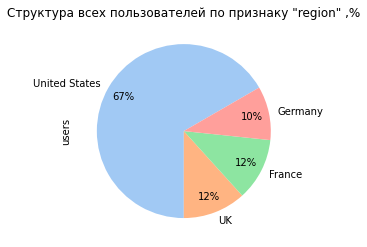

Распределение пользователей по группам:


,users,payers,share_of_payers
region,,,
United States,100002,6902,0.069
Germany,14981,616,0.041
UK,17575,700,0.040
France,17450,663,0.038


In [23]:
# сохраним цветовую палитру для графика
colors = sns.color_palette('pastel')

def share_of_payers(column):
    # считаем количество привлеченных пользователей каждой группы признака,считаем  сколько из них стало покупателями
    # рассчитываем долю платящих пользователей по каждой группе признака
    df = (
    profiles.groupby(column)
    .agg({'user_id': 'nunique', 'payer':['sum','mean']})
    )
    # переименуем стобцы
    df.columns = (['users', 'payers', 'share_of_payers'])
    # округляем долю платящих до трех знаков
    df['share_of_payers'] = df['share_of_payers'].round(3)
    # отсортируем результат по убыванию доли платящих пользователей
    df = df.sort_values(by='share_of_payers', ascending=False)
    # визуализируем общую структуру пользователей по признаку
    df['users'].sort_values(ascending=False).plot(
    kind='pie', figsize=(4,4), colors=colors, autopct='%1.0f%%', pctdistance=0.8, startangle=30
)
    plt.title('Структура всех пользователей по признаку "'+str(column)+'" ,%')
    plt.show()
    print('Распределение пользователей по группам:')
    return df

# применим функцию чтобы определить доли платящих пользователей по странам  
share_of_payers('region')

**Выводы:**    
Пользователи приложения "приходят" из 4 стран: США, Германия, Великобритания и Франция. Подавляющее большинство пользователей приложения (67%) приходит из США, меньше всего - из Германии (10%).     
При этом доля, пользователей, ставших покупателями различается в разных странах, но не в одной из них не превышает и 7%. Наибольшая доля платящих пользователей приходится на США и составляет 6,9%. Интересно, что не смотря на самый низкий показатель числа новых пользователей из Германии, эта страна занимает второе место по проценту платящих пользователей - 4,1%, операжая Великобританию и Францию, у которых этот показатель равен 4,0% и 3,8%, соответственно.


#### Устройства, которыми пользуются клиенты

Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи, для этого построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства c помощью функции `share_of_payers`:

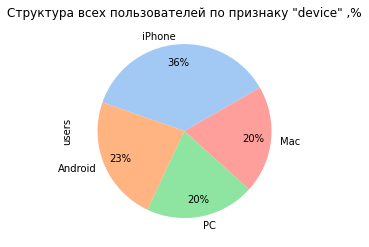

Распределение пользователей по группам:


,users,payers,share_of_payers
device,,,
Mac,30042,1912,0.064
iPhone,54479,3382,0.062
Android,35032,2050,0.059
PC,30455,1537,0.050


In [24]:
share_of_payers('device')

**Выводы:**    
Чуть больше трети пользователей приложения (36%) использует iPhone, на втором месте - Android (23%). РС и Мас для приложения предпочитают использовать реже, но примерно в одинаковых долях (по 20%).    
Доля пользователей, приносящих деньги, выше у Mac и iPhone (6,4% и 6,2%, соответственно), у пользователей Android показатель немного ниже и составляет 5,9%. "Отстающим" по этому показателю среди устройств можно назвать РС - дает 5% платящих пользователей.

#### Рекламные источники привлечения

Выведем на экран рекламные источники привлечения, которые были задействованы для привлечения клиентов:

In [25]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Было 10 рекламных источников.     
Теперь изучим каналы, из которых приходили пользователи в приложение и на какой канал приходится большая доля платящих пользователей. Для этого используем функцию `share_of_payers`, на вход передадим ей параметр `channel`.

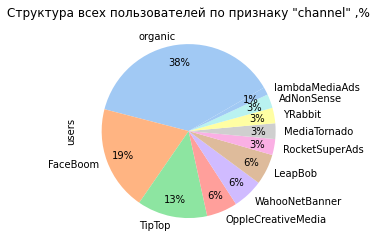

Распределение пользователей по группам:


,users,payers,share_of_payers
channel,,,
FaceBoom,29144,3557,0.122
AdNonSense,3880,440,0.113
lambdaMediaAds,2149,225,0.105
TipTop,19561,1878,0.096
RocketSuperAds,4448,352,0.079
WahooNetBanner,8553,453,0.053
YRabbit,4312,165,0.038
MediaTornado,4364,156,0.036
LeapBob,8553,262,0.031


In [26]:
share_of_payers('channel')

**Выводы:**    
Важно отметить, что значительная часть пользователей "пришла" в приложение самостоятельно, не из рекламы (56439 чел., что составляет 38%). Но не смотря на это, все же большая часть - оказалась в приложении, благодаря рекламным ресурсам.         
Среди рекламных источников наибольшее число пользователей появилось в приложении, благодаря источнику "FaceBoom" (29144 чел.), на втором месте - "TipTop" (19561 чел.).    
Наибольшую долю платящих пользователей обеспечили каналы: "FaceBoom" (12,2%), "AdNonSense" (11,3%) и "lambdaMediaAds" (10,5%). Стоит отметить, что пользователи, пришедшие самостоятельно через канал "organic" - реже всего становятся платящими (таких всего 2,1%).


### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.    
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.   


---

Рассчитаем общую сумму расходов на маркетинг:

In [27]:
costs['costs'].sum().round(2)

105497.3

Определим сколько денег компания израсходовала на каждый рекламный источник:

In [28]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Визуализируем динамику изменений расходов во времени (по неделям и месяцам) по каждому источнику. Для этого преобразуем данные о времени и выделим из даты месяцы и номер недели, затем построим вспомогательные сводные таблицы для визуализации, по которым построим линейные графики

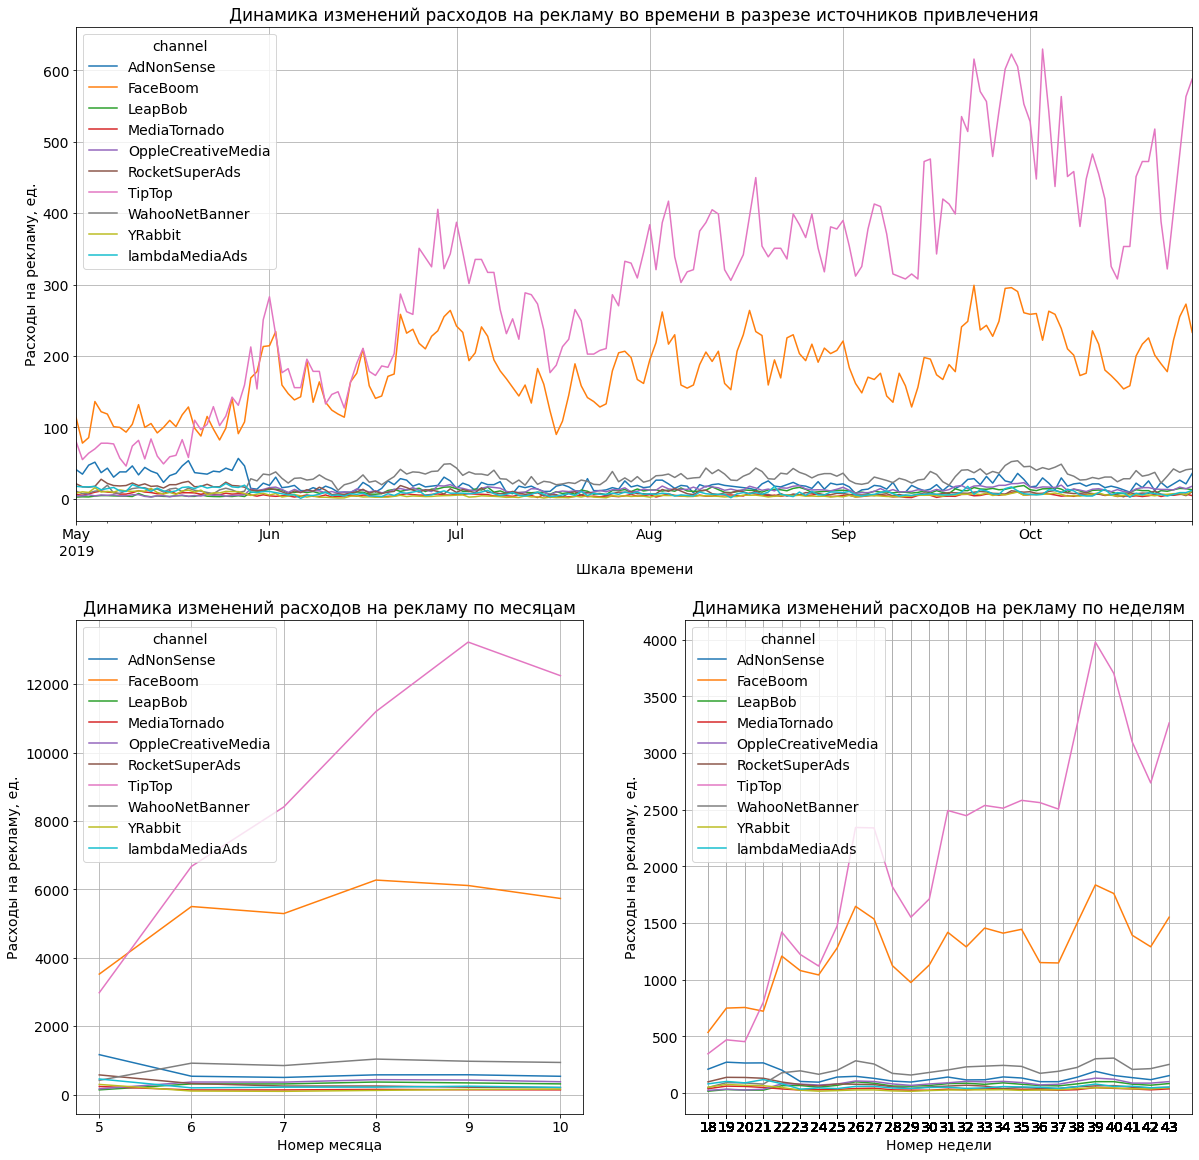

In [29]:
# преобразование данных о времени и создание необходимых столбцов
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].dt.month
costs['week'] = (costs['dt'].dt.isocalendar().week)

# строим фигуру, состоящую из 3 графиков
plt.figure(figsize=(20, 20))
plt.rcParams['font.size'] = '14'

# построим график динамики расходов на рекламу по датам в разрезе источников:
(
    costs.pivot_table(index=['dt'], columns='channel', values='costs', aggfunc='sum')
    .plot(        
        title='Динамика изменений расходов на рекламу во времени в разрезе источников привлечения',
        grid=True,
        ylabel='Расходы на рекламу, ед.',
        xlabel='Шкала времени',
        ax=plt.subplot(2, 1, 1)
    )
)

# строим график динамики по неделям
(
    costs.pivot_table(index=['week'], columns='channel', values='costs', aggfunc='sum')
    .plot(
        title='Динамика изменений расходов на рекламу по неделям',
        grid=True,
        xticks=list(costs['week'].values),
        ylabel='Расходы на рекламу, ед.',
        xlabel='Номер недели',
        ax=plt.subplot(2, 2, 4)
    )
) 
# строим график динамики по месяцам
(
    costs.pivot_table(index=['month'], columns='channel', values='costs', aggfunc='sum')
    .plot(
        title='Динамика изменений расходов на рекламу по месяцам',
        grid=True,
        ylabel='Расходы на рекламу, ед.',
        xlabel='Номер месяца',
        ax=plt.subplot(2, 2, 3)
    )
) 
plt.show()

**Расходы на рекламные источники "TipTop" и "FaceBoom" на протяжении всего времени явно намного выше, чем у остальных источников.** Среди лидеров можно заметить некое периодическое повторение элементов недельного временного ряда: подъем - спуск, подъем - спуск и т.д. Так, первый пик вложений в рекламу пришелся на 22-ю неделю (конец мая), следующий - на 26-27 недели (конец июня - начало июля) и самый значимый пик приходится на 39-40 недели (конец сентября - начало октября). Что касается остальных источников, то расходы на них не превышают 2000 единиц измерения стоимости в месяц, в то время как у лидеров этот показатель в несколько раз выше.     
Например, у "TipTop", в целом, виден ежемесячный рост расходов на рекламу, а в сентябре он достиг рекордных отметок - свыше 12000 едениц стоимости, после - пошел на спад.

Узнаем сколько, в среднем, стоило привлечение одного пользователя (CAC) из каждого источника.    
В датафрейме `profiles` есть столбец `acquisition_cost` со стоимостью привлечения каждого пользователя приложения. Исключим из профелей когорты, появившиеся позже `max_analysis_date` и сгруппируем профили по каналам,  среди групп найдем среднее значение стоимости привлечения одного пользователя `acquisition_cost`.

In [30]:
channel_cac = (
    profiles.query('dt <@max_analysis_date')
    .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
    .rename(columns={'acquisition_cost': 'cac_mean'})
    .sort_values(by='cac_mean', ascending=False)
)
channel_cac.round(2)   

,cac_mean
channel,
TipTop,2.75
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.73
WahooNetBanner,0.60
RocketSuperAds,0.42
OppleCreativeMedia,0.25
MediaTornado,0.22
YRabbit,0.22


Теперь выясним, как менялась стоимость привлечения для каждого источника от когорты к когорте. Для этого построим сводную таблицу, в которой названиями строк будут даты привлечения пользователей, названиями столбцов — каналы привлечения, а значениями — средний CAC, и построим по ней график истории изменений.

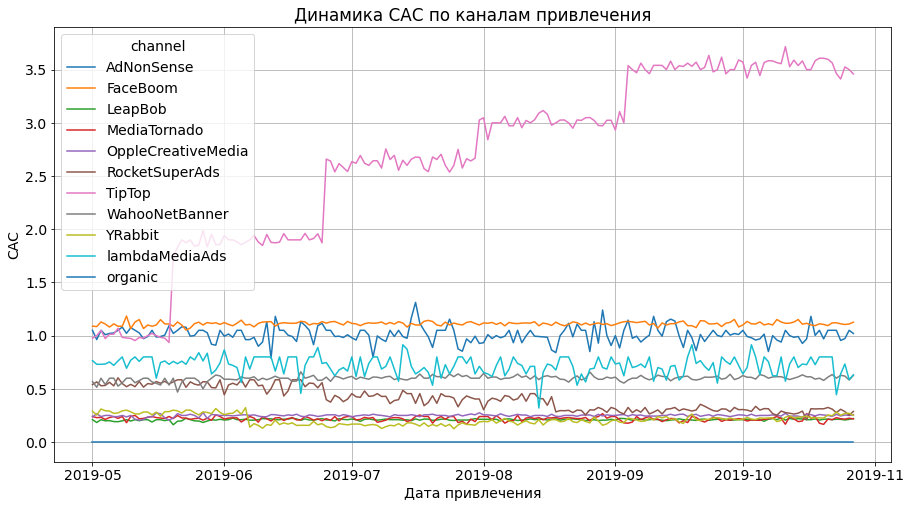

In [31]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

**Выводы:**    
Общая сумма расходов компании на маркетинг составила 105497.30 единиц измерения стоимости. Из них 54751.30 единиц (или 52% всех рекламных расходов) потрачено на источник "TipTop", 32445.60 (или 31%) - на "FaceBoom", а оставшиеся 18300.40(или 17%) - распределены между еще 8 рекламными источниками.  

Анализ динамики изменений расходов во времени показал, что вложение средств в рекламу через большинство источников, в целом, проходило стабильно, без резких увеличений или уменьшений вложений, не превышая 1000 единиц стоимости в месяц. Важно, что компания, явно видела перспективу в источниках "TipTop" и "FaceBoom", вкладывая в них средств в несколько раз больше, чем в другие источники. Что касается, самого дорогостоящего источника "TipTop", то ежемесячно вплоть до сентября компания вкладывала в него все больше денег (в сентябре показатель достиг уровня свыше 12000 ед.). Второй по размерам вложений источник "FaceBoom" получал средства не в таких стремительных темпах, максимальная сумма ежемесячных расходов по нему зафиксирована в августе, слегка превысив 6000.    

Рассмотрев динамику стоимости привлечения пользователя, можно сказать, что самыми "дорогими" пользователями для компании стали пользователи из рекламного канала "TipTop". В среднем, стоимость привлечения одного такого пользователя обошлась в 2,75 ед. Показатель от когорты к когорте не был стабильным и за изучаемый период варьировал приблизительно от 1 до 3,5.  Судя по графику, с некоторой периодичностью в нескольких кагортах происходили заметные скачки роста данного показателя.    
Стоимости привлечения одного пользователя остальных рекламных источников, в целом, стабильны от когорты к когорте. Пожалуй, одним из самых стабильных можно назвать источник "FaceBoom" - привличение одного пользователя из него обошлось компании в средненм в 1,11 ед.     
Стоимость привлечения «органических» пользователей во всех когортах равна нулю, так как они пришли в приложение самостоятельно и компании они обошлись бесплатно. 


### Оценка окупаемости рекламы

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

---

#### Анализ окупаемости рекламы c помощью графиков LTV и ROI,  графики динамики LTV, CAC и ROI

Для наиболее точного анализа окупаемости рекламы, исключим из анализа "органических" пользователей, на привлечение которых компания не затрачивала средства, таким образом дальнейший анализ будем проводить на "рекламных" пользователях. Посмотрим на общую окупаемость рекламы, рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`

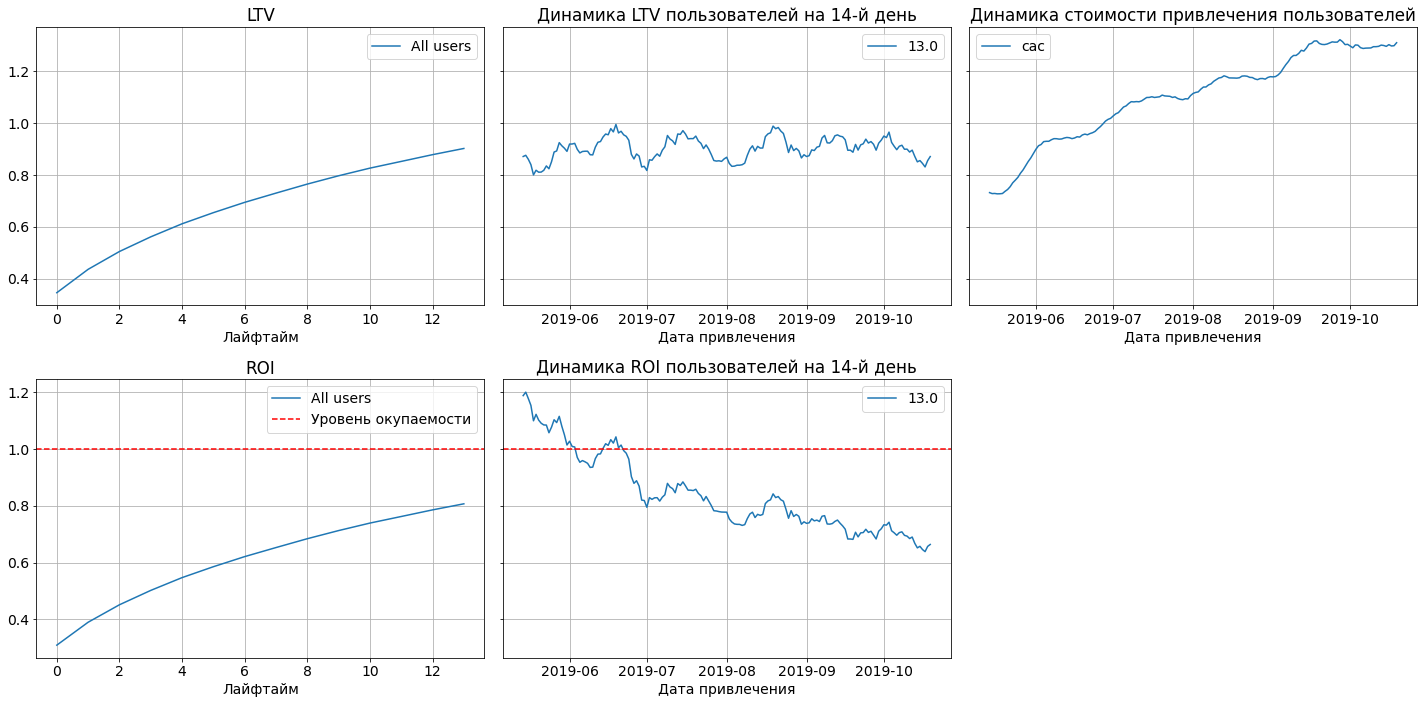

In [32]:
# исключаем органических пользователей
profiles = profiles.query('channel != "organic"')

# # считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Из графиков следует, что:    
1. Реклама не окупается, показатель оккупаемости ROI к концу второй недели - чуть выше 80% (то есть сумма денег, которую в среднем, компании приностит один клиент ниже, чем затраты на его привлечение).     
2. Показатель стоимости привлечения одного клиента CAC - не стабилен и растет с течением времени. - Вероятно, проблема бизнеса кроется в постоянном увеличении рекламного бюджета.
3. LTV растет в пределах когорты. В динамике от когорты к когорте на 14-й день он подвержен небольшим колебаниям, напоминающим "сезонность" но, в целом, достаточно стабилен. Значит, дело не в ухудшении качества пользователей.   
4. ROI на 14-й день в динамике постепенно снижается, что происходит на фоне роста САС (с июня - ни разу не превысил 1).

Чтобы более глубоко разобраться в причинах происходящего, проанализируем оккупаемость рекламы с разбивкой по некоторым характеристикам пользователей.

#### Оккупаемость рекламы с разбивкой по устройствам

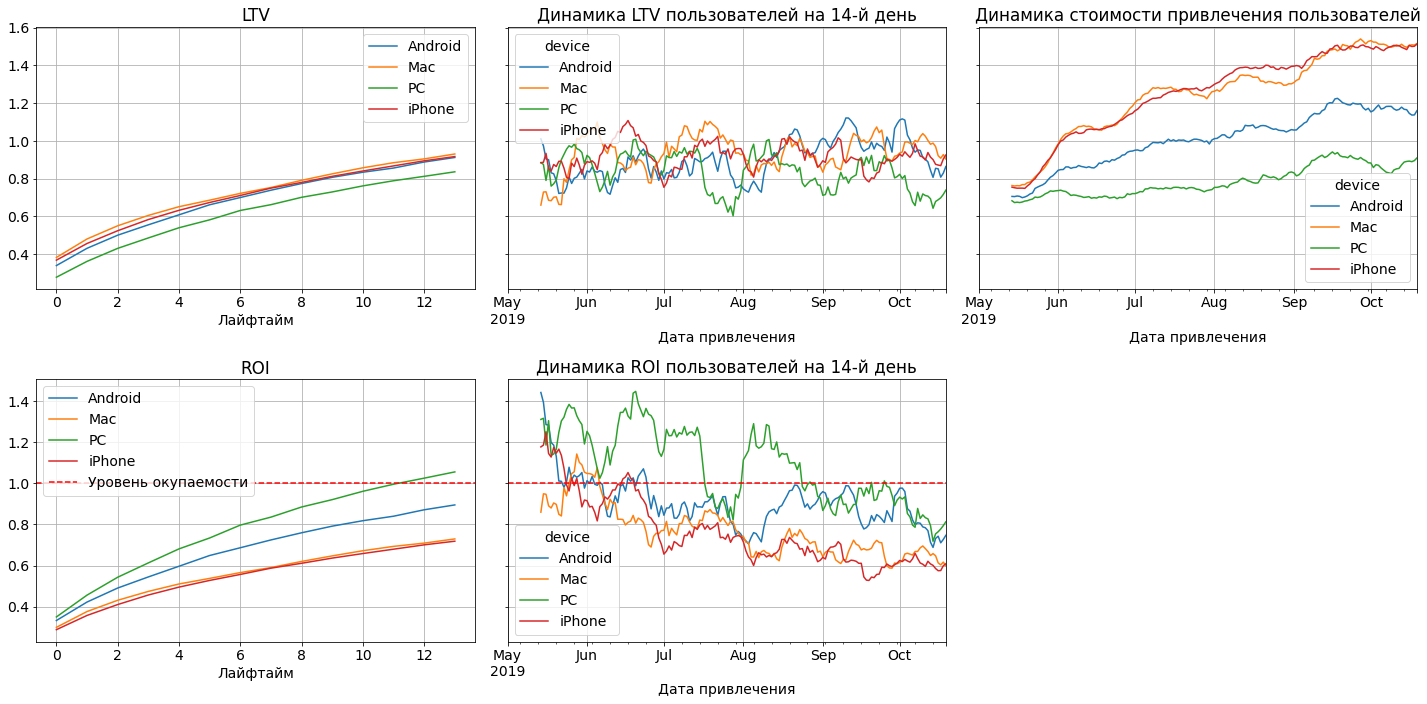

In [33]:
# строим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Интересно, что окупается только реклама для пользователей персональных компьютеров PC, что, вероятно, обусловлено самыми низкими расходами на рекламу, стоимость привлечения одного пользователя РС заметно ниже, чем пользователей других устройств на протяжении всего времени. В то же время, из графика LTV видно, что "качество" пользователей РС - ниже, чем у других устройств.    

Стоит отметить, что **сложнее всего окупается реклама для пользователей устройств iPhone и Mac**, что обусловлено неоправданно высокими затратами на их привлечение.   
В целом, графики почти повторяют динамику без разбивки.

#### Оккупаемость рекламы с разбивкой по странам

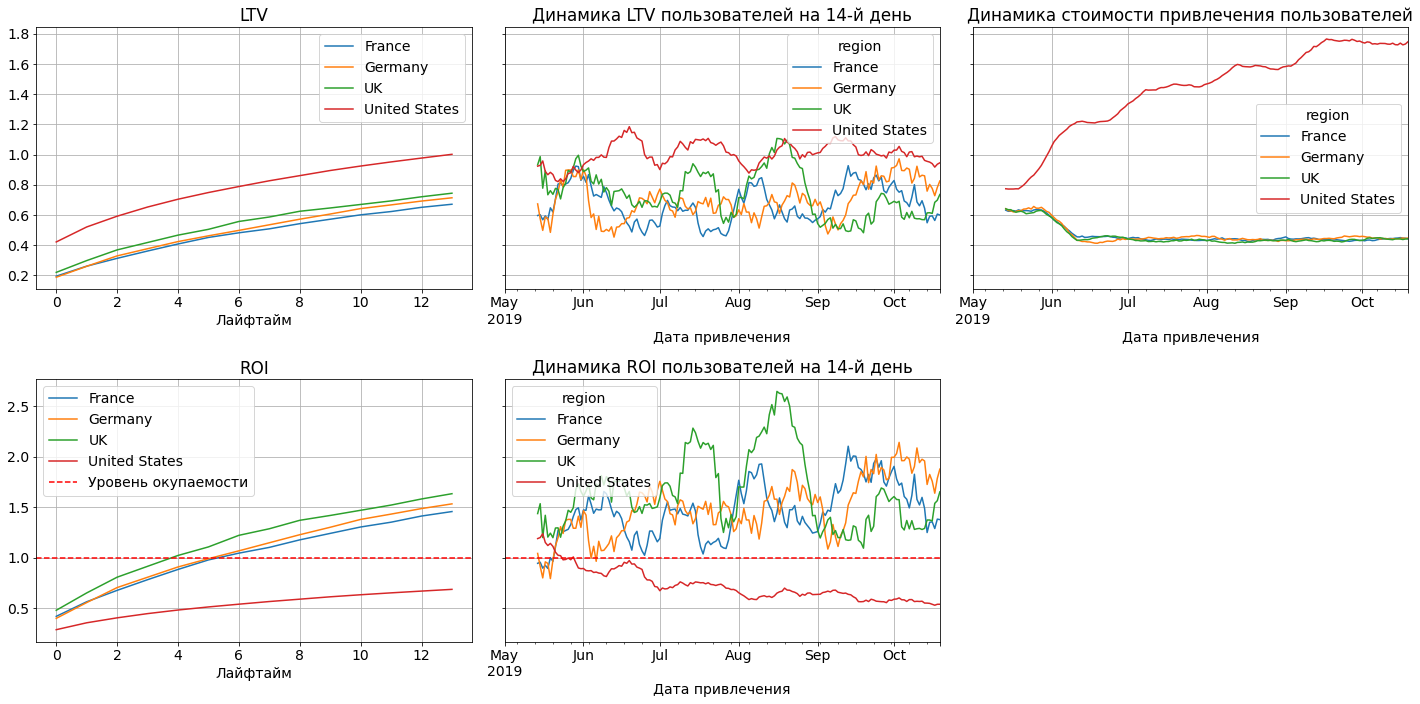

In [34]:
# строим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Оказывается, реклама окупается для пользователей всех стран, кроме США. Стоимость привлечения одного пользователя в динамике растет также только среди пользователей США, что ярко демонстрирует проблему бизнеса. Возможно, компания в силу многочисленности аудитории из США в какой-то момент приняла решение повысить расходы на рекламу именно в этой стране, за счет сокращения расходов на рекламу в других странах. Это видно на графике: как только стоимость привлечения в США начала расти, через небольшой промежуток времени в других странах произошел ее спад. Стоимость привлечения там с тех пор остается почти стабильной,  в США же наблюдается дальнейший рост.     
Динамика ROI на 14-й день говорит о том, что расходы на рекламу США окупались лишь в начале, начиная с июня, коэффициент ни разу не превысил уровень окупаемости, ни в одной из когорт, прослеживается тенденция к его снижению.    
Стоит отметить, что самыми ценными клиентами, судя по LTV, являются как раз клиенты из США. **Но даже их "качественности" (способности приность денег больше, чем все остальные клиенты) - недостаточно для покрытия таких высоких рекламных расходов, стоит на это обратить внимание.**

#### Оккупаемость рекламы с разбивкой по рекламным каналам

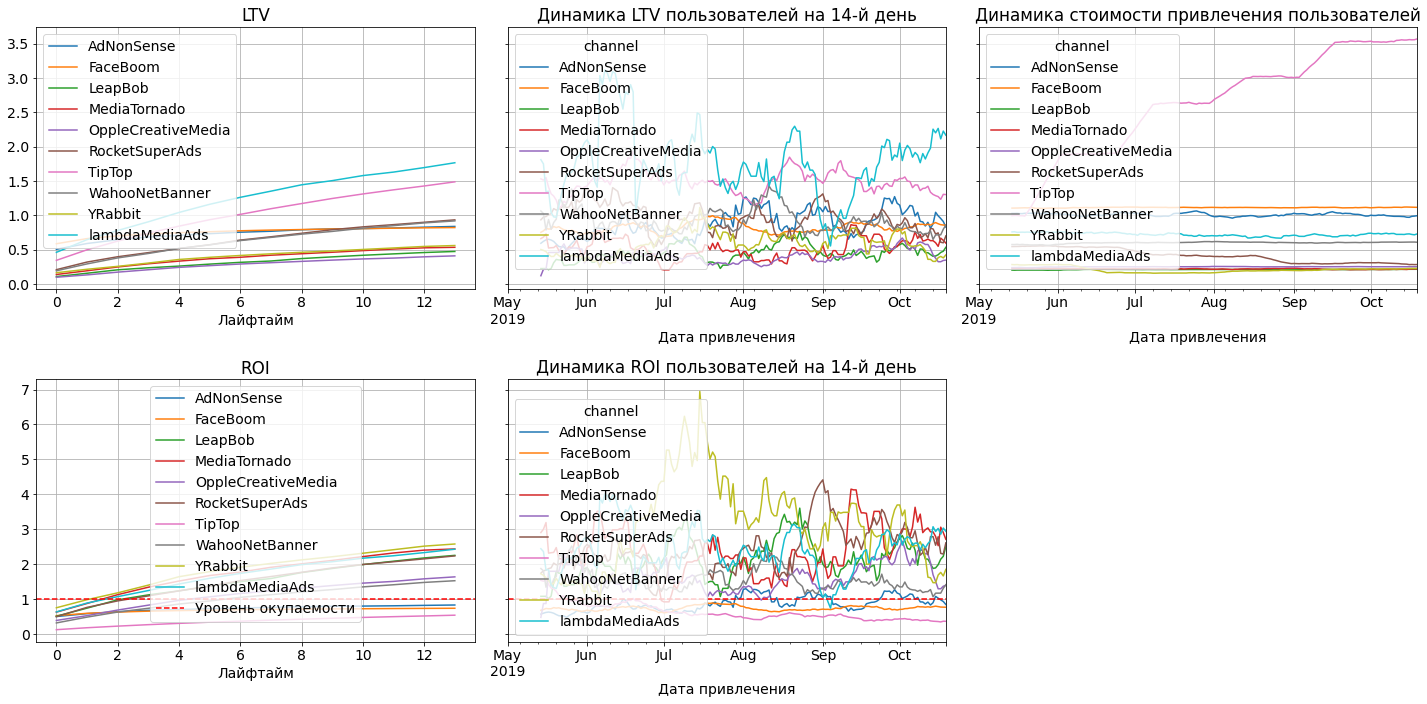

In [35]:
# строим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

В динамике стоимости привлечения одного пользователя активный рост наблюдается у знакомого канала "TipTop", остальные каналы в этом вопросе стабильны.        
Самыми "качественными" пользователями являются те, кто пришли через канал "lambdaMediaAds" и через самый дорогостоящий для компании канал "TipTop". Но несмотря на это, пока уровня LTV канала "TipTop" не достаточно, для покрытия высоких рекламных расходов, они не окупаются. Кроме "TipTop" за изучаемый период времени, не окупились еще 2 рекламные источника: "AdNonSense" и "FaceBoom". 

#### Конверсия и удержание пользователей, динамика их изменения

Проверим общую конверсию и удержание пользователей, динамику их изменения, вызвав функции `get_conversion()` и `plot_conversion()`, `get_retention()` и `plot_retention()`.

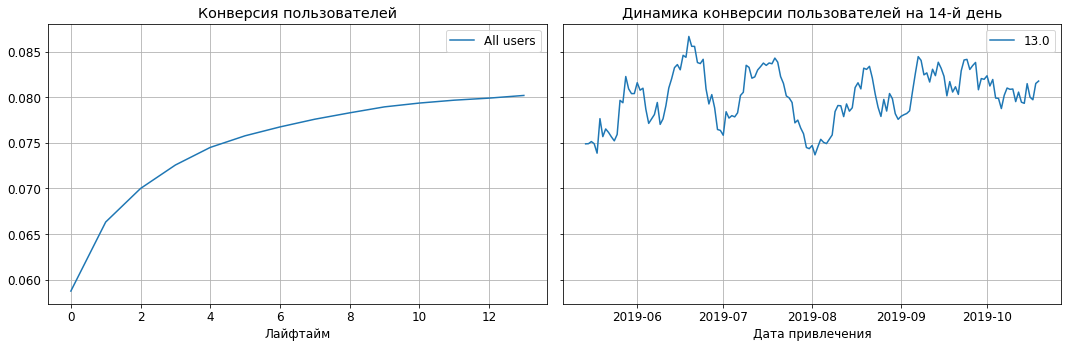

In [36]:
plt.rcParams['font.size'] = '12'
# строим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

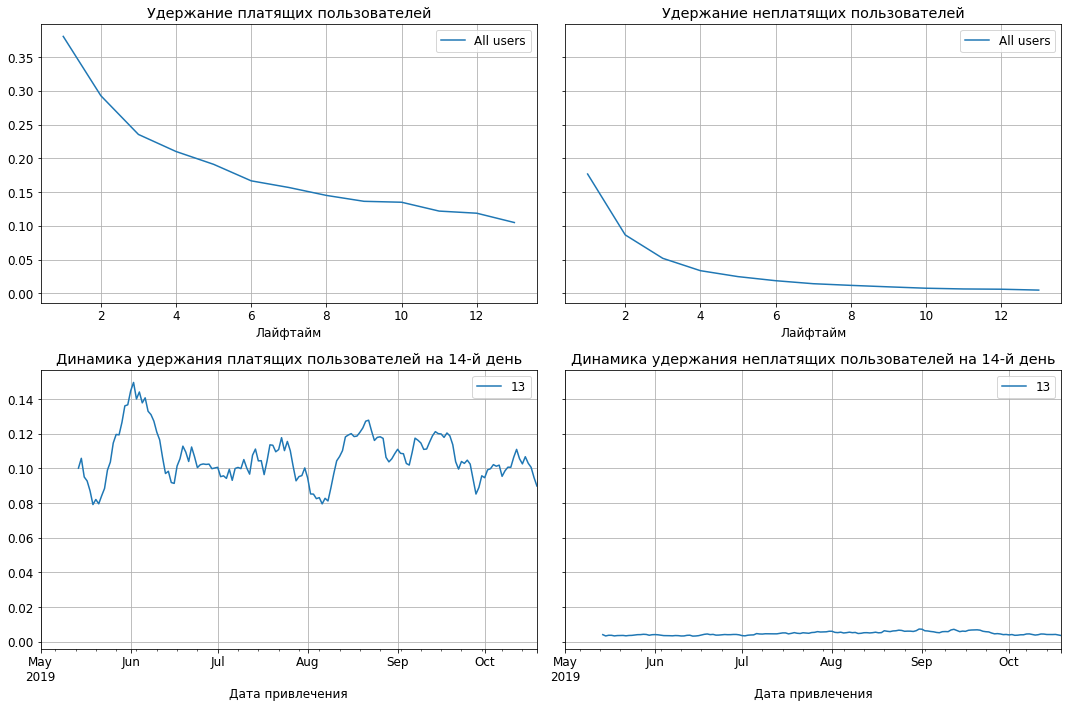

In [37]:
# смотрим общее удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Анализ общих показателей говорит, что конвертируются пользователи, в целом, нормально (в динамике на 14-й день показатель составляет примерно от 74 % и выше), а удерживаются пользователи хуже: в динамике на 14-й день в приложении остаются примерно 8-15% пользователей. После предыдущего этапа появилась небольшая зацепка, поэтому проверим конверсию пользователей и динамику её изменения в разрезе стран, рекламных компаний и устройств.

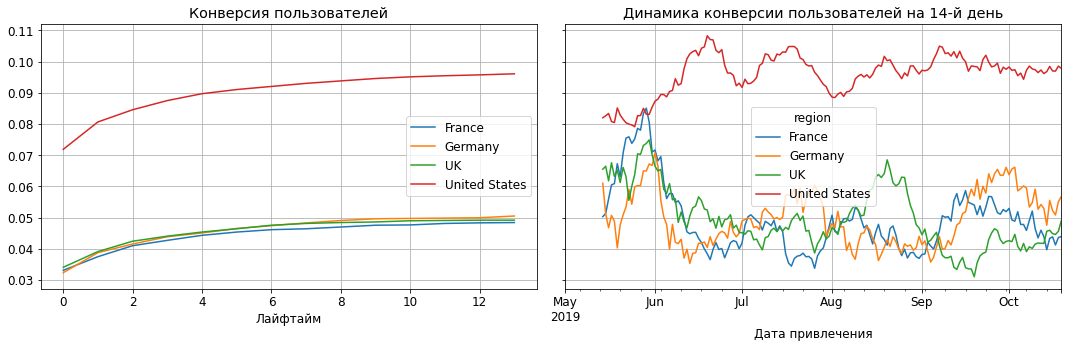

In [38]:
# строим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Судя по графикам, пользователи США конвертируются очень хорошо, причем постоянно. Проверим как удерживаются пользователи из разных стран. Вызовем функции `get_retention()` и `plot_retention()`.

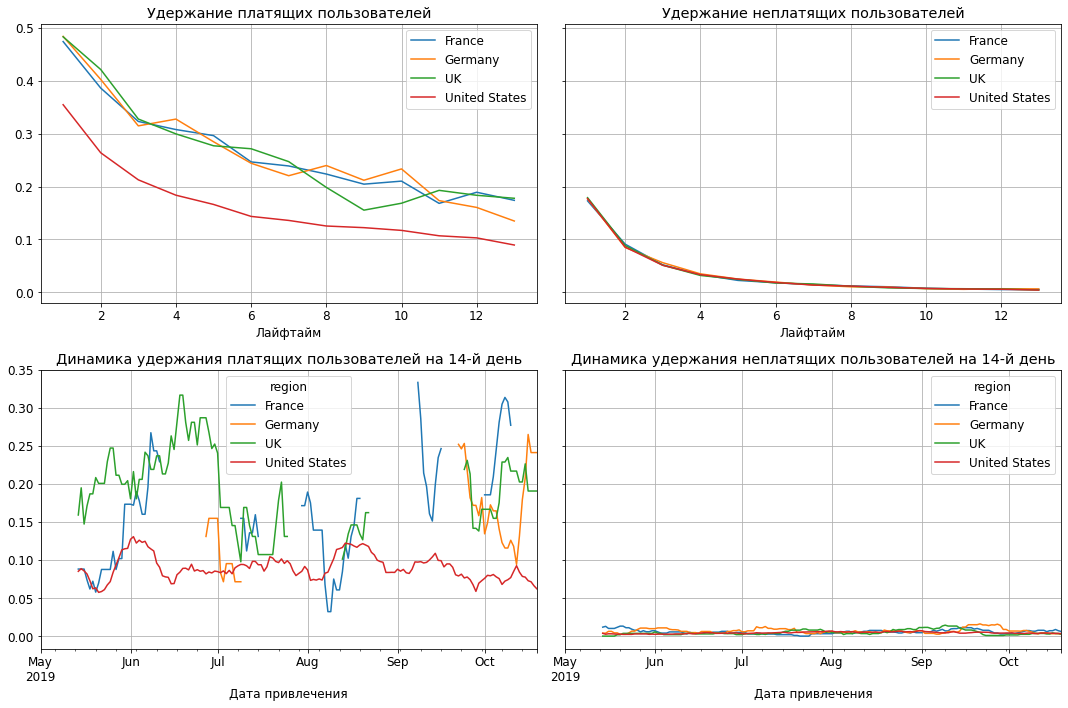

In [39]:
# строим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

А вот удерживаются пользователи из США намного хуже, чем из других стран, причем платящие. Показатель в динамике на протяжении изучаемого периода не превышает 15%. Возможно, существует какая-то техническая проблема, чтобы это выяснить не хватает данных, неплохо бы изучить этот момент.

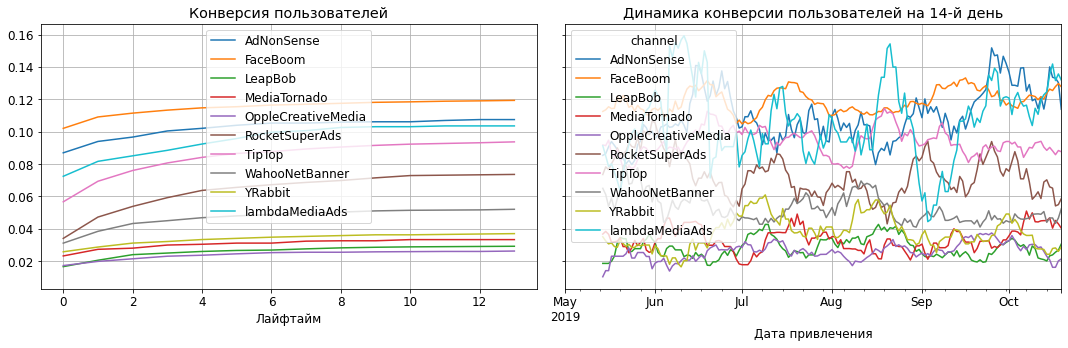

In [40]:
# строим конверсию с разбивкой по рекламным источникам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Пользователи из неокупающихся каналов "TipTop", "AdNonSense" и "FaceBoom" конвертируются лучше, чем другие источники, поэтому посмотрим как они удерживаются.

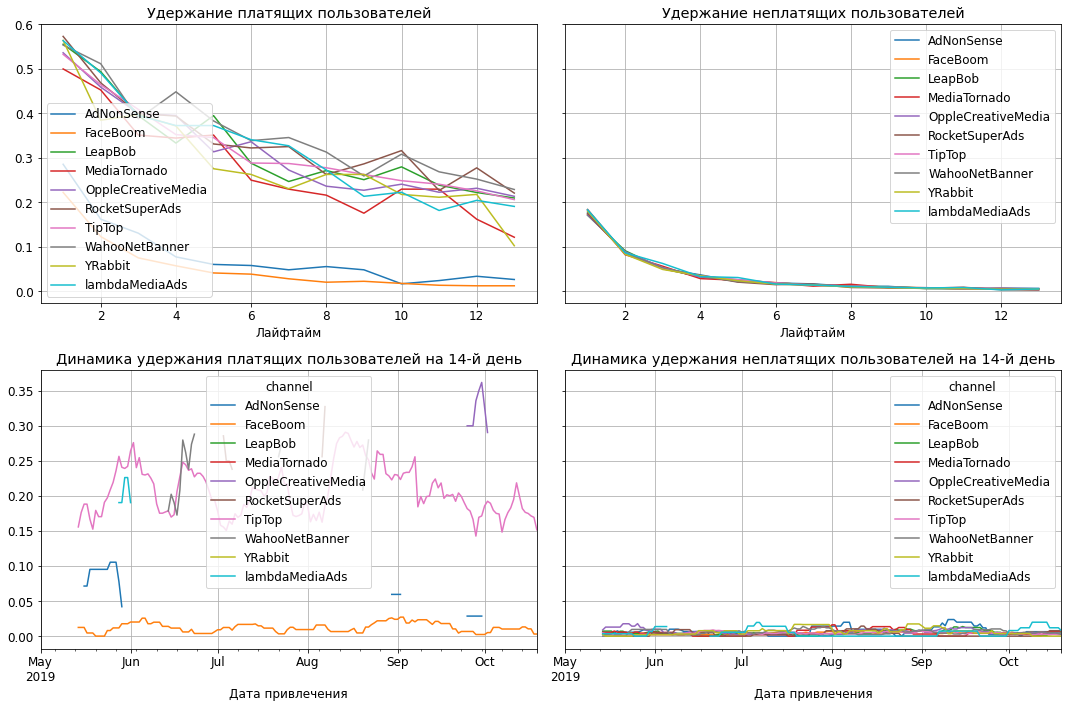

In [41]:
# строим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Интересно, что пользователи из "TipTop" удерживаются на уровне пользователей из других каналов. Здесь можно говорить о слишком высоких расходах на рекламу, которые не оправдывают себя.   
Хуже всех удерживаются пользователи из "FaceBoom", на 14-й день их удержание не превышало 5%, явно существует какая-то проблема, с которой сталкиваются эти пользователи. Еще плохо удерживаются пользователи из канала "AdNonSense".

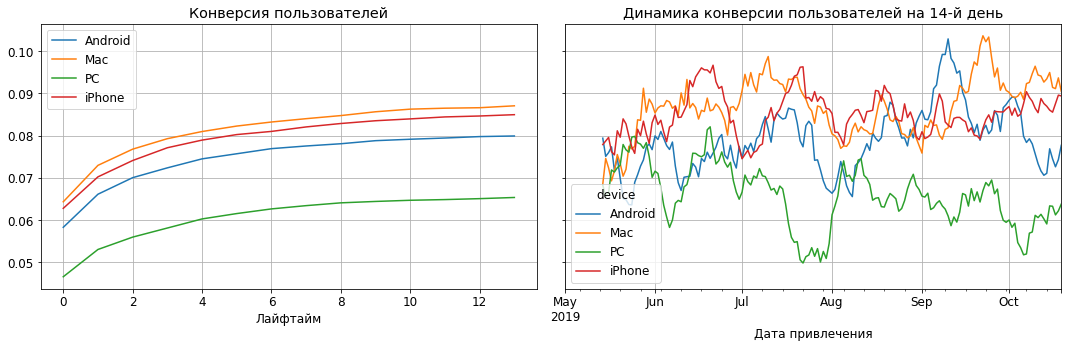

In [42]:
# строим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

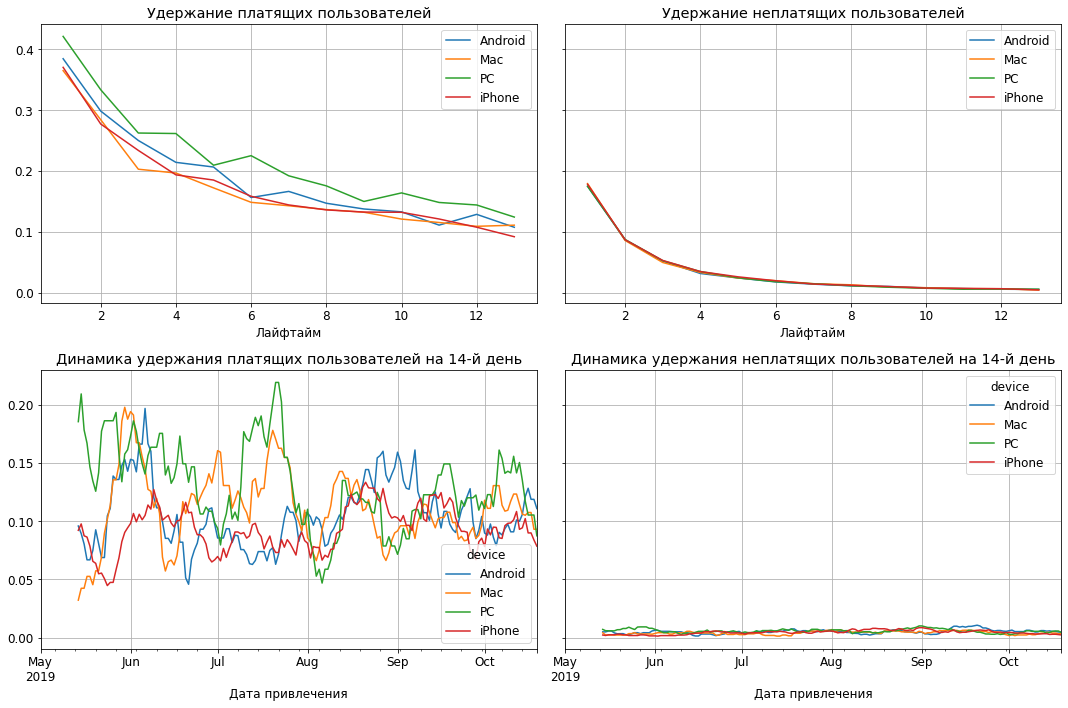

In [43]:
# строим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Лучше всего конвертируются пользователи "Мас" и "iPhone", хуже - "РС". Удерживаются платящие пользователи разных устройств примерно на  одном уровне, но пользователи "РС" удерживаюся немногим лучше, чем остальные.

**Выводы:**   
Реклама, направленная на привлечение пользователей в целом, не окупилась (показатель окупаемости ROI к концу второй недели составляет чуть выше 80%). Расходы на рекламу постоянно растут.    

Негативное влияние на окупаемость рекламы могут оказывать:    
1. **Из устройств: пользователи 'Mac', 'iPhone' и 'Android'**. Уровень ROI для 'Mac' и 'Android' к концу второй недели составляет немногим выше 70%, в то время как показатель 'Android' стремится к 90%. Удерживаются пользователи всех устройств примерно равнозначно с небольшими отличиями. Важно отметить, что несмотря на окупаемость пользователей "РС", наиболее "качественными" для бизнеса можно считать пользователей 'Mac' и 'iPhone'. Поэтому, возможно, стоит пересмотреть уровень расходов на рекламу данных категорий, поскольку стоимость привлечения клиентов здесь заметно выше, чем у остальных пользователей.
2. **Из стран: пользователи США.**  Самыми конвертируемыми пользователями с наиболее высоким уровнем LTV являются пользователи из США. Но бизнесу стоит обратить внимание, что расходы на рекламу для пользователей этой страны не окупаются, стоимость привлечения одного пользователя здесь обходится на порядок дороже, чем пользователя из другой страны, и постоянно растет.  Важно отметить, что пользователи США удерживаются в приложении стабильно хуже, чем другие пользователи, что, в свою очередь, может быть следствием скрытых проблем - например, технических. Чтобы это выяснить наверняка - нужен дополнительный набор данных от разработчиков с информацией о проблемах, с которыми сталкиваются пользователи во время работы в приложении для дополнительного анализа.     
3. **Из рекламных источников: пользователи "TipTop", "AdNonSense" и "FaceBoom".** Пользователи, пришедшие через эти рекламные каналы не окупились. Причем пользователи из "TipTop" и "FaceBoom" по динамике ROI на 14-й день не пересекли уровень окупаемости ни разу. В целом, пользователи из "TipTop" имеют среднестатистические показатели конверсии, неплохой уровень LTV и удержания, поэтому, возможно, стоит пересмотреть уровень расходов на рекламу и попробовать их перераспределить, поскольку стоимость привлечения одного пользователя очень высока и постоянно растет. Что касается пользователей из "AdNonSense" и "FaceBoom", то они неплохо конвертируются, но стабильно плохо удерживаются, стоимость их привлечения достаточно стабильна, поэтому стоит обратить внимание на изучение технических характеристик, связанных с этими каналами.    

Таким образом, проблемы окупаемости могут быть вызваны слишком высокими расходами компании на рекламу, а также низким удержанием платящих пользователей из США и пользователей, пришедших из каналов "FaceBoom" и "AdNonSense".

### Сравнение окупаемости американских и европейский рекламных источников

Из анализа выше вытекает различие в поведении американских и европейских пользователей.    
Поэтому для более корректного перераспределения потока рекламных ресурсов считаем разумным разделить пользователей на американских и европейских и проанализировать по отдельности окупаемость в разрезе рекламных источников, также построим конверсию и удержание по ним.

#### Пользователи из США

In [44]:
# отбираем профили американских пользователей
profiles_USA = profiles.query('region == "United States"')

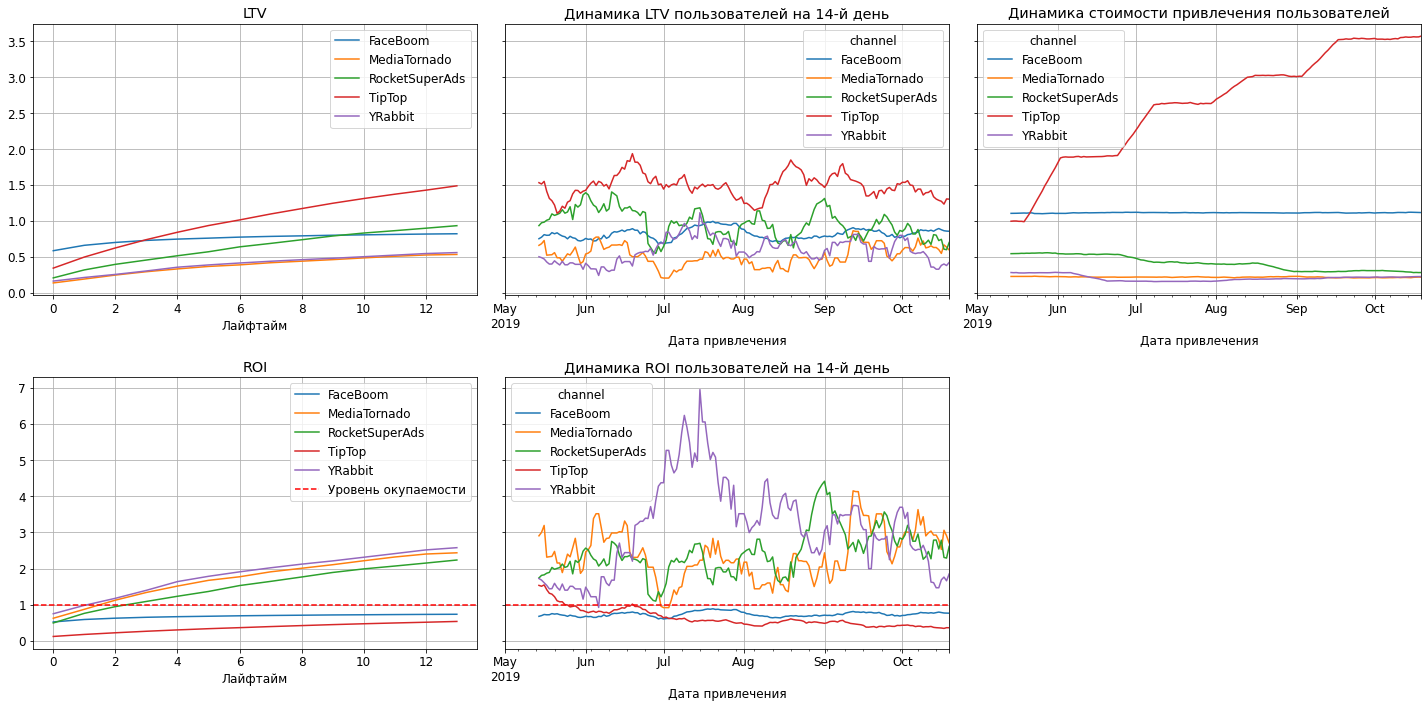

In [45]:
# строим окупаемость с разбивкой по рекламным каналам для пользователей из США

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

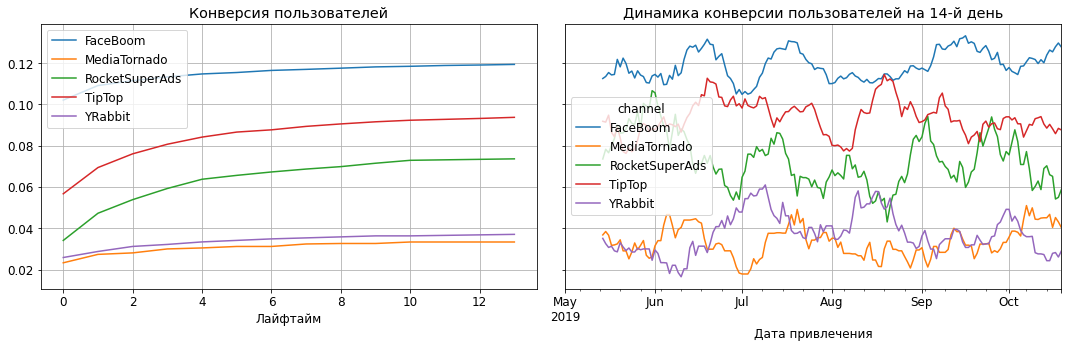

In [46]:
# строим конверсию пользователей из США с разбивкой по рекламным источникам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

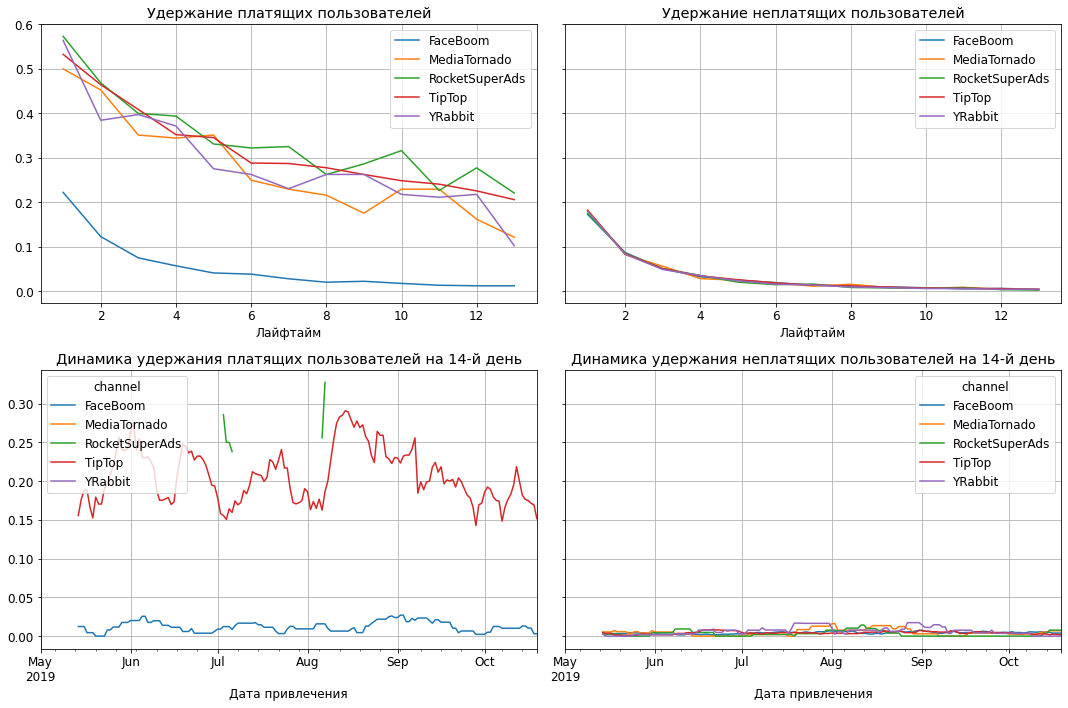

In [47]:
# строим удержание пользователей из США с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_USA, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

**В США не окупаются два рекламных источника: знакомые нам "TipTop" и "FaceBoom". Расходы на привлечение одного пользователя через источник "TipTop" постоянно растут. Платящие пользователи из источника "FaceBoom" стабильно плохо удерживаются.  
Бизнесу стоит обратить внимание на истоники "YRabbit", "MediaTornado" и "RocketSuperAds".**

#### Европейские пользователи

In [48]:
# отбираем профили европейских пользователей
profiles_EU = profiles.query('region != "United States"')

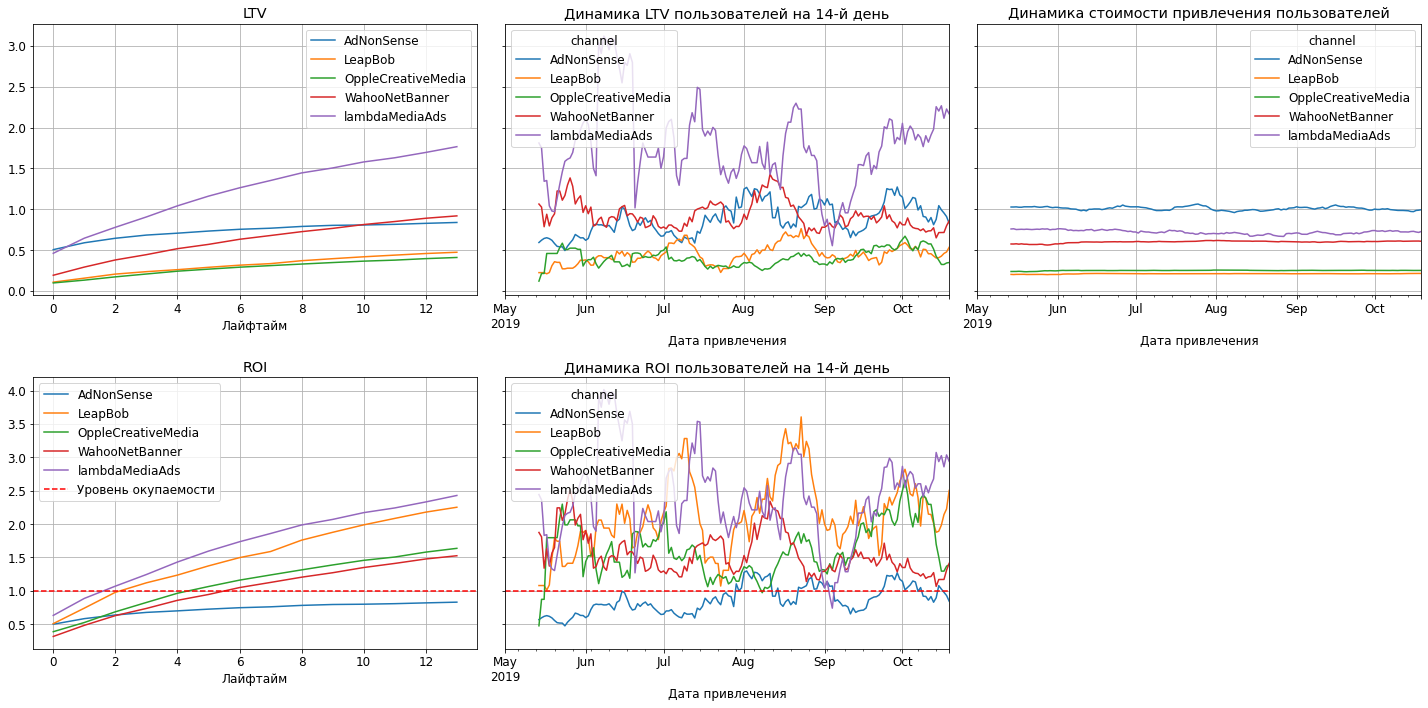

In [49]:
# строим окупаемость с разбивкой по рекламным каналам для пользователей из Европы

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_EU, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

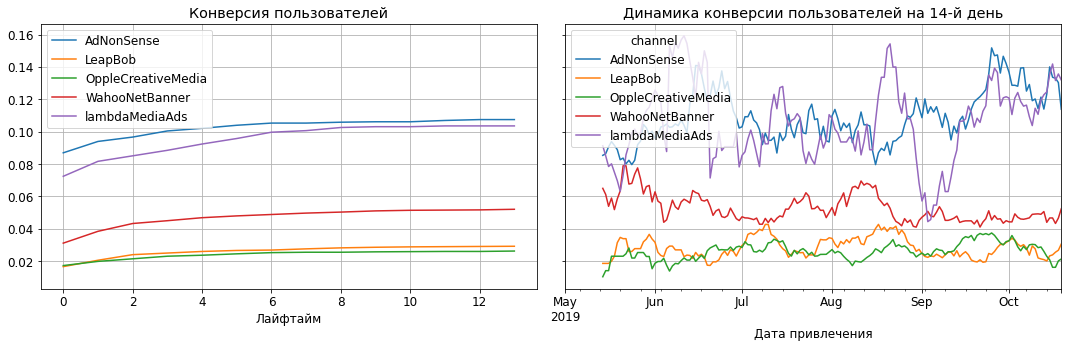

In [50]:
# строим конверсию пользователей из Европы с разбивкой по рекламным источникам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_EU, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

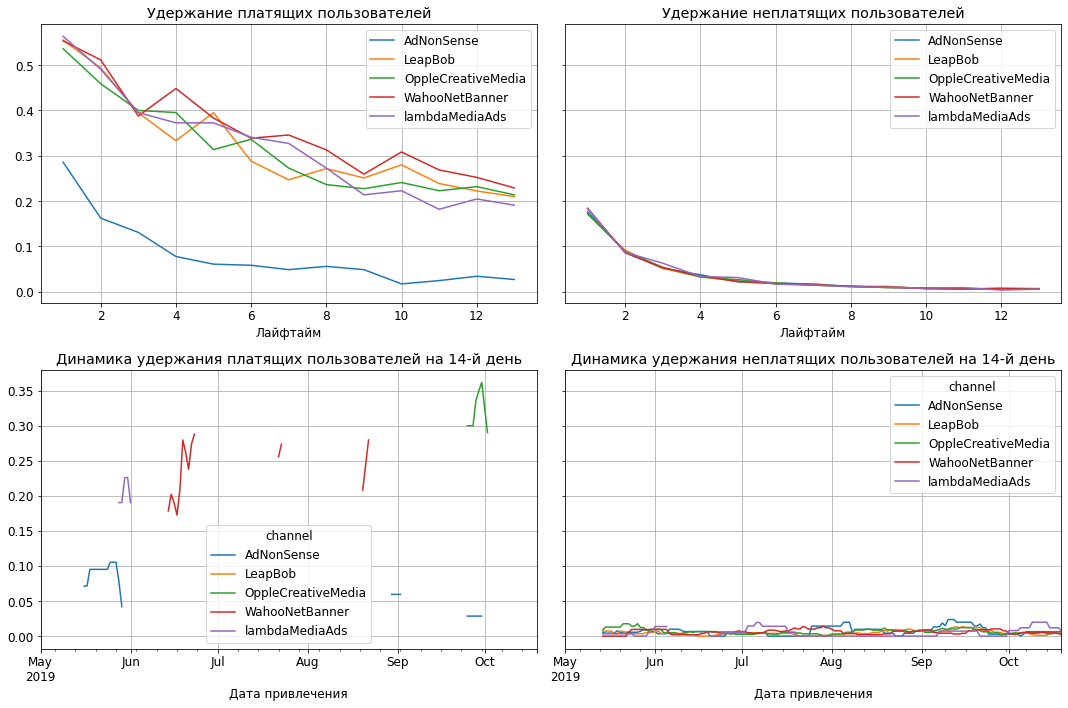

In [51]:
# строим удержание пользователей из Европы с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_EU, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

**На европейском рынке не окупается канал "AdNonSense", он же стабильно плохо удерживается. Затраты на привлечение пользователей по нему в целом стабильны, но выше, чем у остальных каналов. Бизнесу стоит присмотреться к каналам "LeapBob" и "lambdaMediaAds", уровень их окупаемости выше, чем у других каналов.**

### Выводы по исследованию

В исследовании были составлены профили пользователей развлекательного приложения.    
Приложение используют в 4 странах: США, Великобритания, Франция и Германия. 67% клиентов - пользователи из США.    
Для приложения пользователи предпочитают использовать разные девайсы: 36% - iPhone, 23% - Android, РС и Мас - в равных долях(по 20%).   
Не смотря на то, что 38% пользователей "приходят" в приложение самостоятельно, всё же большая часть оказывается в нем, благодаря рекламным ресурсам. Что касается оплат, то "органические" пользователи платят редко - в 2,1% случаев, поэтому для данного исследования эта категория интереса не представляет, в связи с чем принято решение ее исключить.    

За изучаемый период на рекламу всего было израсходовано 105497,30 единиц измерения стоимости. Из них 83% потрачено на 2 рекламных источника: "TipTop" - 54751,30 единиц и "FaceBoom" - 32445,60 единиц, оставшиеся средства распределены еще между 8 рекламными каналами. Стоимость привлечения одного пользователя через канал "TipTop" активно растет на протяжении изучаемого периода. Так, привлечение одного пользователя через "TipTop", в среднем, обошлось в 2,75 единиц, а "FaceBoom" - 1,11 единиц.

Расходы на рекламу, в целом, не окупаются. Таким образом гипотеза подтвердилась.    
Причинами неэффективности привлечения могут быть неоправданно высокие расходы на привлечение пользователей. Сейчас компания на рекламу тратит средств больше, чем ей приносит клиент. Так, высокая стоимость привлечения пользователя выявлена для пользователей из США, для пользователей 'Mac' и 'iPhone', для пользователей, пришедших из канала "TipTop".

Стоит отметить, что кроме постоянного увеличения рекламного бюджета, среди некоторых крупных по численности групп пользователей, выявлен низкий уровень удержания Retention Rate. Так, существует проблема с удержанием пользователей из США и пользователей, прешедших через канал "FaceBoom". Здесь резонно выяснить что не позволяет пользователям удерживаться лучше. В связи с этим считаем разумным запросить данные с информацией об ошибках, с которыми сталкиваются пользователи при работе с приложением, и выполнить дополнительный анализ по пользователям из США и "FaceBoom". По возможности, неплохо было бы изучить их отзывы и пользовательские рейтинги.    

Отделу маркетинга рекомендуется пересмотреть рекламные расходы на источник привлечения "TipTop" в сторону уменьшения. Также стоит заострить внимание на рациональности высокой стоимости привлечения клиентов из США. Среди пользователей из Америки окупаются следующие рекламные источники: "YRabbit", "MediaTornado" и "RocketSuperAds", возможно, стоит перераспределить высокие рекламные расходы с истоника "TipTop" и "FaceBoom" в их сторону.     
Что касается европейского рынка, то здесь окупаются все рекламные источнки за исключением "AdNonSense", платящие пользователи из которого стабильно плохо удерживаются, а стоимость привлечения одного пользователя выше, чем у остальных источников. Наибольший уровень окупаемости у источников "LeapBob" и "lambdaMediaAds". Возможно, расходы на источник "AdNonSense" также стоит перераспределить в пользу источников-лидеров.